In [1]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Activation, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from keras import backend as K
from google.colab import files, drive
from skimage.io import imread, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
import os
import io
import zipfile
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
class image_generator(Sequence):

    def __init__(self, image_filenames, mask_filenames, batch_size, img_size, n_calsses, loss='categorical_crossentropy', no_reshape=False):
        self.image_filenames, self.mask_filenames = image_filenames, mask_filenames
        self.batch_size = batch_size
        self.height = img_size[0]
        self.width = img_size[1]
        self.n_calsses = n_calsses
        self.no_reshape = no_reshape
        self.loss = loss

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def get_img_array(self, file_name):
      img = cv2.imread(file_name, 3)
      return (cv2.resize(img, (self.width, self.height))/255).astype('float32')

    def get_segmentation_mask(self, file_name, sparse=False):
        img = cv2.imread(file_name, 1)
        img = cv2.resize(img, (self.width, self.height), interpolation=cv2.INTER_NEAREST)
        img = img[:, :, 0]
        img = img.max() - img
        if sparse:
              img = np.reshape(img, (self.height*self.width))
              return np.expand_dims(img,2).astype('uint8')
        seg_labels = np.zeros((self.height, self.width, self.n_calsses))
        for c in range(self.n_calsses):
          seg_labels[:, :, c] = (img == c).astype(int)
        if not self.no_reshape:
          seg_labels = np.reshape(seg_labels, (self.height*self.width, self.n_calsses))
        return seg_labels.astype('bool')
  
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.loss == 'categorical_crossentropy':
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))
        else:
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))

In [0]:
def mean_iou(y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)

In [0]:
def show_predictions():
    file_name_img = "image_table_val_resized/5_table.png"
    file_name_mask = "mask_binary_cell_val_resized/5_table.png"
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmin(axis=2)
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
input_height = 512
input_width = 1024
n_classes = 2
batch_size = 4
loss = 'binary_crossentropy'
optimizer = optimizers.Adam()

In [6]:
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/tabOCR/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
uploaded = files.upload()
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_table_cells_binary.zip']), 'r')
data.extractall()

In [0]:
image_filenames = list(map(lambda s: "image_table_train_resized/" + s, sorted(os.listdir('image_table_train_resized'))))
mask_filenames = list(map(lambda s: "mask_binary_cell_train_resized/" + s, sorted(os.listdir('mask_binary_cell_train_resized'))))
image_filenames_val = list(map(lambda s: "image_table_val_resized/" + s, sorted(os.listdir('image_table_val_resized'))))
mask_filenames_val = list(map(lambda s: "mask_binary_cell_val_resized/" + s, sorted(os.listdir('mask_binary_cell_val_resized'))))
train_generator = image_generator(image_filenames, mask_filenames, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
val_generator = image_generator(image_filenames_val, mask_filenames_val, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)

In [10]:
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
batch1 = BatchNormalization()(conv1)
batch1 = Activation('relu')(batch1)
pool1 = MaxPooling2D((4, 4))(batch1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
batch2 = BatchNormalization()(conv2)
batch2 = Activation('relu')(batch2)

pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv4)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('sigmoid')(out)

model = Model(img_input, out)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 1024, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 1024, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 1024, 32 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 1024, 32 9248       

In [11]:
model.compile(optimizer=optimizer, loss=loss, metrics=[mean_iou])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
# fit generator
# filepath = root_path + "outputs/model_table_simple_borders_all.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='mean_iou', verbose=1, save_best_only=True, mode='max', period=1)
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=2,
                               monitor='mean_iou',
                               patience=2, verbose=1,
                               min_lr=0.1e-7)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto')
# callbacks list
callbacks_list = [lr_reducer, early_stopping, DisplayCallback()]



Epoch 1/15
1000/1000 [==============================] - 304s 304ms/step - loss: 0.0281 - mean_iou: 0.7187 - val_loss: 0.0174 - val_mean_iou: 0.8130


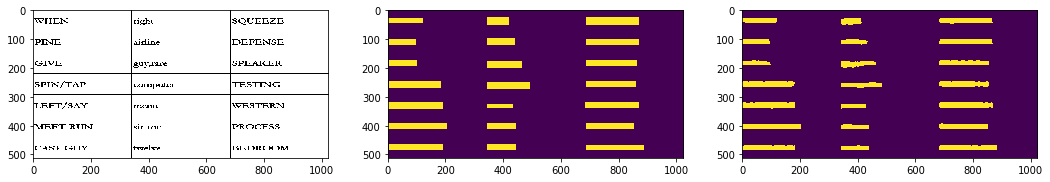


Sample Prediction after epoch 1

Epoch 2/15
1000/1000 [==============================] - 291s 291ms/step - loss: 0.0165 - mean_iou: 0.8339 - val_loss: 0.0150 - val_mean_iou: 0.8477


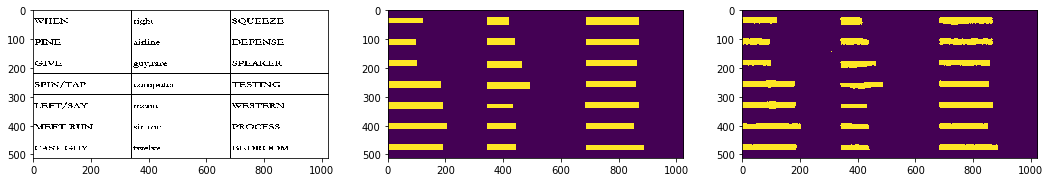


Sample Prediction after epoch 2

Epoch 3/15
1000/1000 [==============================] - 291s 291ms/step - loss: 0.0151 - mean_iou: 0.8558 - val_loss: 0.0144 - val_mean_iou: 0.8614

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


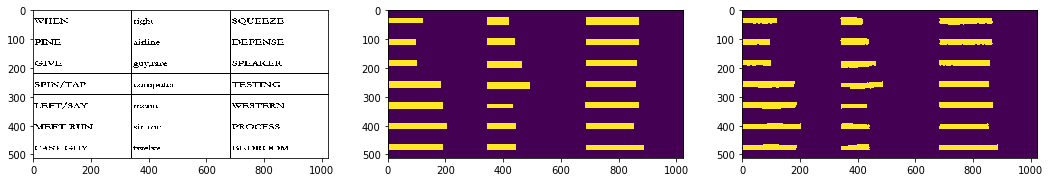


Sample Prediction after epoch 3

Epoch 4/15
1000/1000 [==============================] - 291s 291ms/step - loss: 0.0136 - mean_iou: 0.8659 - val_loss: 0.0136 - val_mean_iou: 0.8699


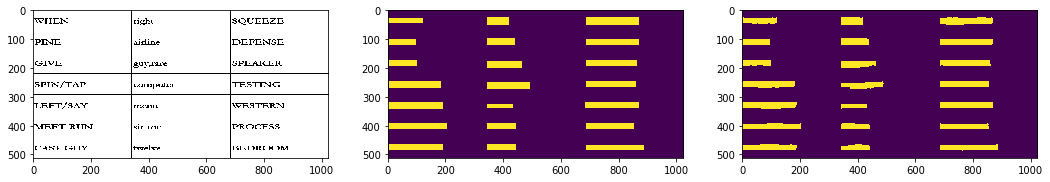


Sample Prediction after epoch 4

Epoch 5/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0133 - mean_iou: 0.8729 - val_loss: 0.0135 - val_mean_iou: 0.8754


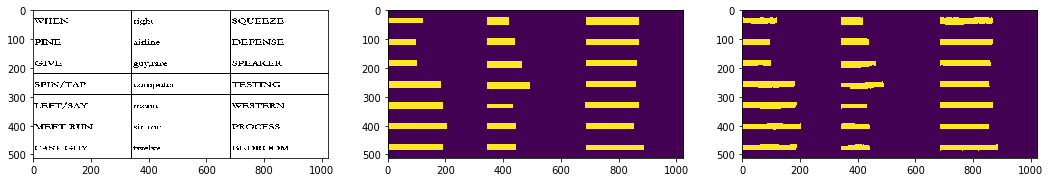


Sample Prediction after epoch 5

Epoch 6/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0131 - mean_iou: 0.8773 - val_loss: 0.0131 - val_mean_iou: 0.8792

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


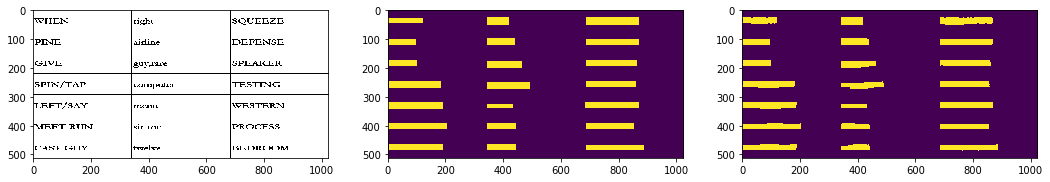


Sample Prediction after epoch 6

Epoch 7/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0128 - mean_iou: 0.8808 - val_loss: 0.0130 - val_mean_iou: 0.8823


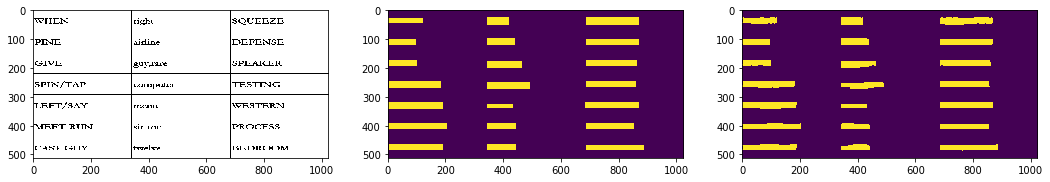


Sample Prediction after epoch 7

Epoch 8/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0128 - mean_iou: 0.8835 - val_loss: 0.0130 - val_mean_iou: 0.8846


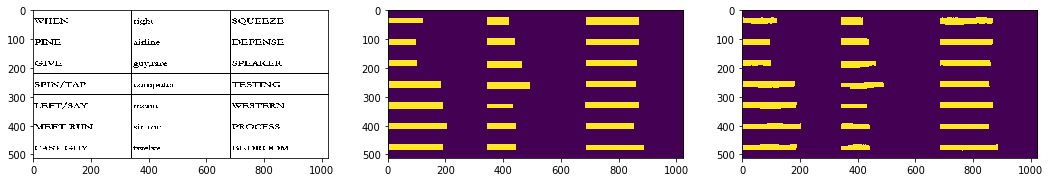


Sample Prediction after epoch 8

Epoch 9/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0128 - mean_iou: 0.8855 - val_loss: 0.0130 - val_mean_iou: 0.8864

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


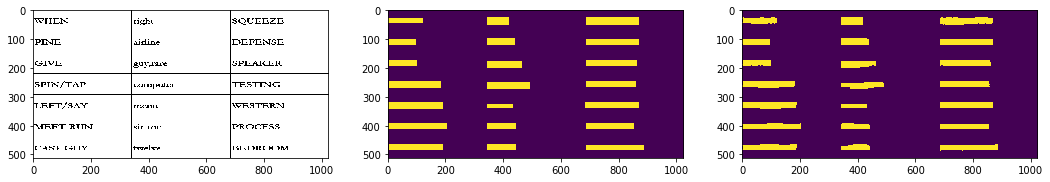


Sample Prediction after epoch 9

Epoch 10/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0127 - mean_iou: 0.8872 - val_loss: 0.0130 - val_mean_iou: 0.8879


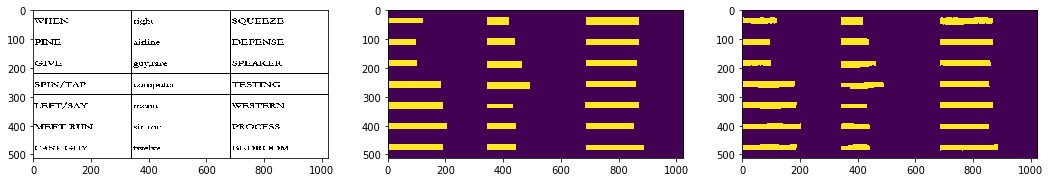


Sample Prediction after epoch 10

Epoch 11/15
1000/1000 [==============================] - 293s 293ms/step - loss: 0.0128 - mean_iou: 0.8885 - val_loss: 0.0130 - val_mean_iou: 0.8892


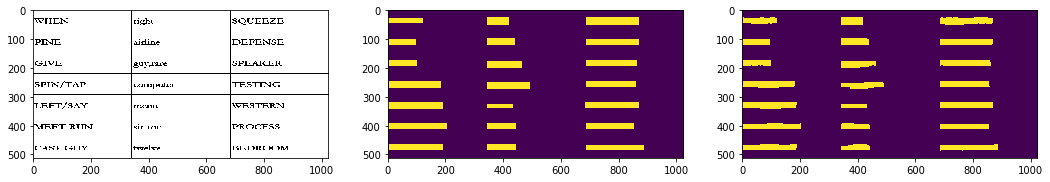


Sample Prediction after epoch 11

Epoch 12/15
1000/1000 [==============================] - 293s 293ms/step - loss: 0.0127 - mean_iou: 0.8896 - val_loss: 0.0130 - val_mean_iou: 0.8901

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.


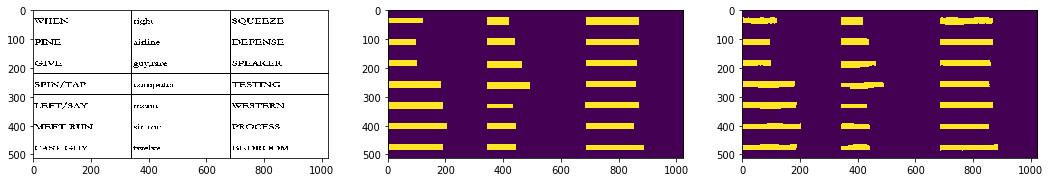


Sample Prediction after epoch 12

Epoch 13/15
1000/1000 [==============================] - 294s 294ms/step - loss: 0.0128 - mean_iou: 0.8906 - val_loss: 0.0129 - val_mean_iou: 0.8910


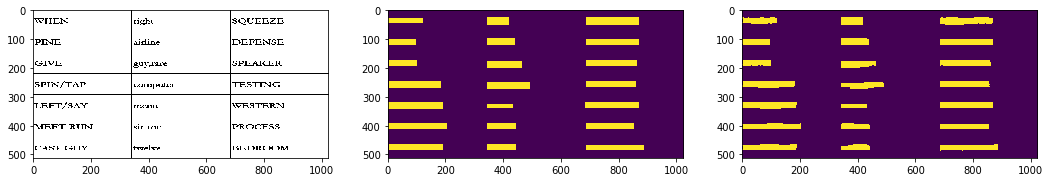


Sample Prediction after epoch 13

Epoch 14/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0127 - mean_iou: 0.8915 - val_loss: 0.0129 - val_mean_iou: 0.8918


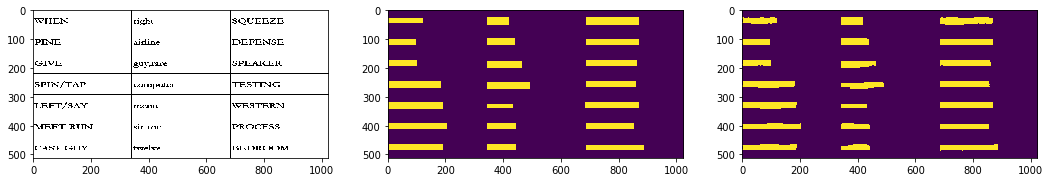


Sample Prediction after epoch 14

Epoch 15/15
1000/1000 [==============================] - 292s 292ms/step - loss: 0.0128 - mean_iou: 0.8921 - val_loss: 0.0129 - val_mean_iou: 0.8925

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.


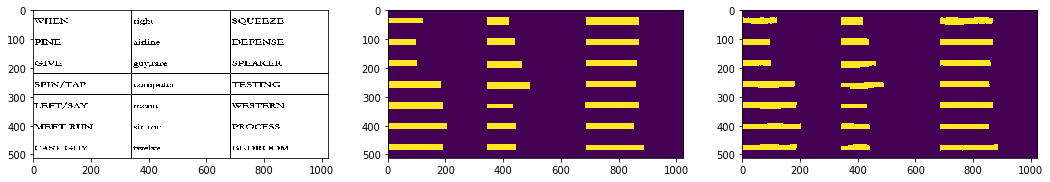


Sample Prediction after epoch 15



In [13]:
history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=15,
                              steps_per_epoch=1000,
                              callbacks=callbacks_list,
                              workers=2,
                              use_multiprocessing=True,
                              verbose=1)

(1, 512, 1024, 3) (512, 1024)


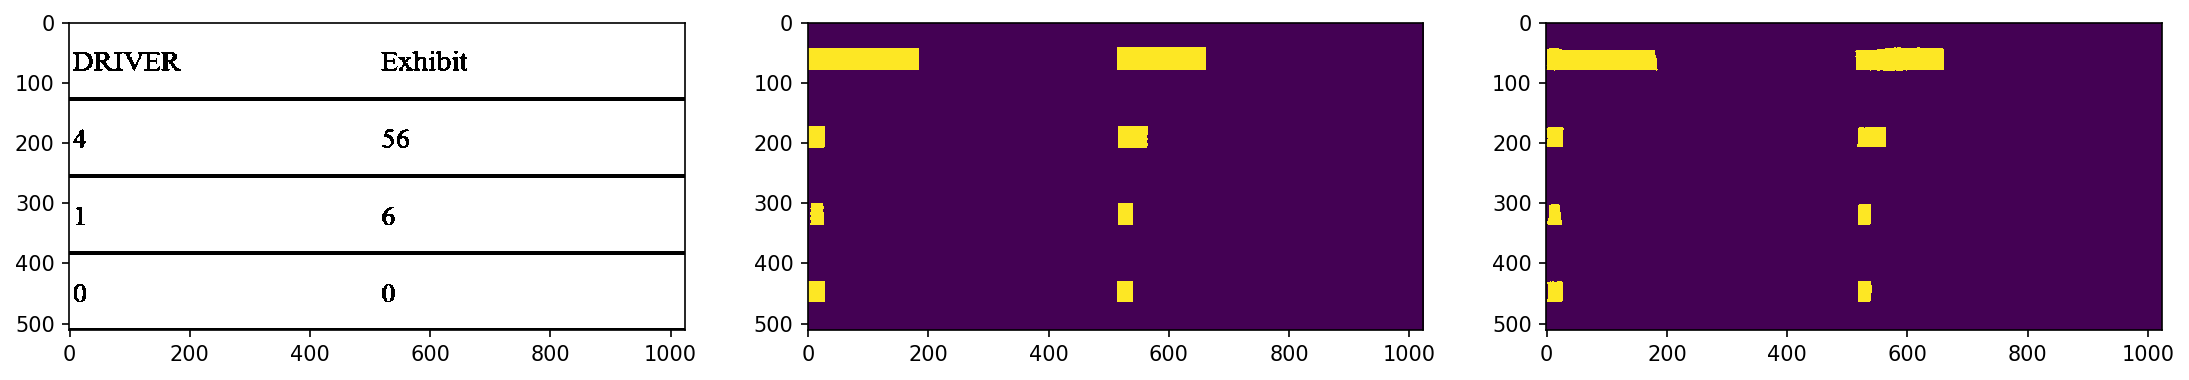

In [14]:
def predict(model, file_name_img, file_name_mask, input_height, input_width, n_classes):
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_width, input_height),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    print(img_test.shape, img_mask.shape)
    mask_pred_raw = model.predict(img_test.astype('float32'))
    mask_pred = mask_pred_raw.reshape((input_height, input_width, n_classes)).\
        argmin(axis=2)
    plt.figure(figsize=(18, 18), dpi=150)
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()
    return mask_pred_raw


mask_pred_raw = predict(model, "image_table_test_resized/0_table.png", "mask_binary_cell_test_resized/0_table.png", input_height, input_width, n_classes)

In [0]:
model.save(root_path + '/model_table_cells_binary.h5')